In [2]:
import pandas as pd                     
import numpy as np

In [3]:
#import the csv file
oilPrices = pd.read_csv('/Users/noah/Documents/Personal Projects/oil/oil updated/BrentOilPrices2.csv')
#change column names to more comfortable names
oilPrices.columns=['date', 'price']
#Cast Date Column to type date
oilPrices['date'] = pd.to_datetime(oilPrices['date'])
print("Data Set:"% oilPrices.columns, oilPrices.shape)
print("Data Types:", oilPrices.dtypes)
#Check the top five records
oilPrices.head()

Data Set: (8360, 2)
Data Types: date     datetime64[ns]
price           float64
dtype: object


,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
oilPrices.set_index('date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [5]:
oilPrices.isnull().values.any()

False

In [6]:
oilPrices['year']=oilPrices['date'].dt.year
oilPrices['month']=oilPrices['date'].dt.month
oilPrices['week']=oilPrices['date'].dt.week

In [7]:
train = oilPrices[(oilPrices['date' ] > '2000-01-01') & (oilPrices['date' ] <= '2020-04-16')]
test = oilPrices[oilPrices['date' ] >= '2020-04-17']

In [8]:
#pip install matplotlib

In [9]:
from matplotlib import pyplot as plt

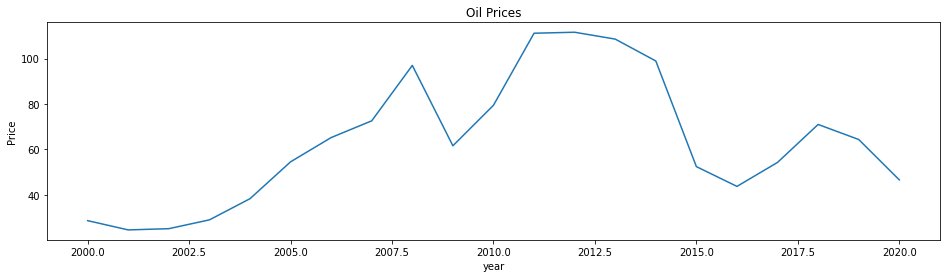

In [10]:
yearlyPrice=train.groupby(["year"])['price'].mean()
plt.figure(figsize=(16,4))
plt.title('Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
yearlyPrice.plot()
plt.show();

In [11]:
#Convert to Time Series For ARIMA Estimator
series=pd.Series(data=train['price'].to_numpy(), index=train['date'])

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.975765
p-value: 0.297299


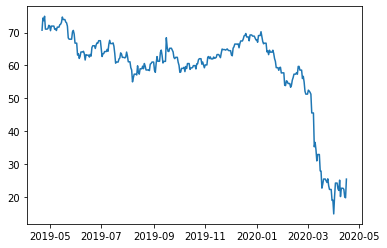

In [13]:
plt.plot(series[7050:7950,])
plt.show()

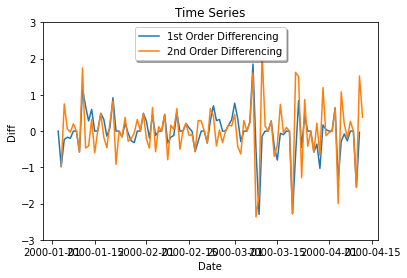

In [14]:
daily_series_diff1 = series.diff(periods=1).dropna()
daily_series_diff2 = daily_series_diff1.diff(periods=1).dropna()
fig, ax = plt.subplots()
ax.plot(daily_series_diff1[0:100], label='1st Order Differencing')
ax.plot(daily_series_diff2[0:100], label='2nd Order Differencing')
plt.ylim([-3,3])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Diff')
plt.show()

In [15]:
#pip install pmdarima --user

In [16]:
#Number of differences required for a stationary series
from pmdarima.arima.utils import ndiffs
y=series
# augmented Dickey–Fuller test (adf test)
print("ADF Test: ",ndiffs(y, test='adf'))
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

ADF Test:  1
KPSS Test:  1
PP Test:  1


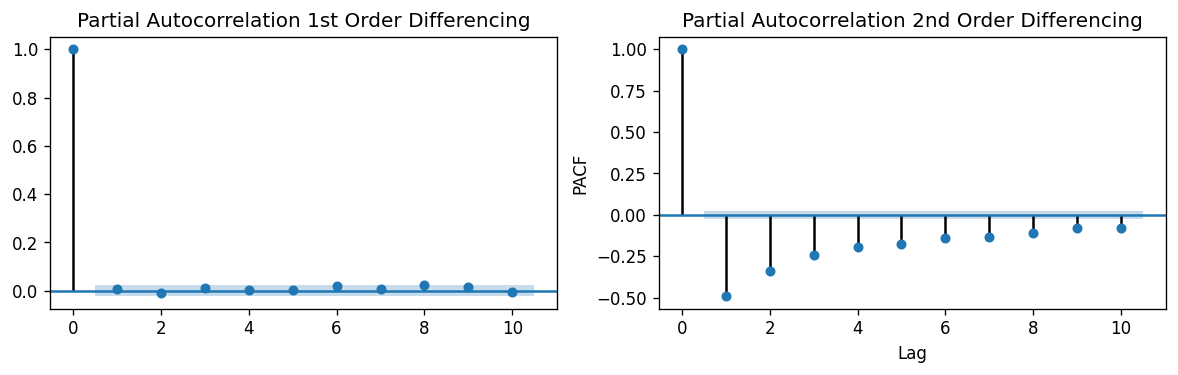

In [17]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_pacf(daily_series_diff1, lags=10, ax=axes[0], title="Partial Autocorrelation 1st Order Differencing")
plot_pacf(daily_series_diff2, lags=10, ax=axes[1], title="Partial Autocorrelation 2nd Order Differencing")
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

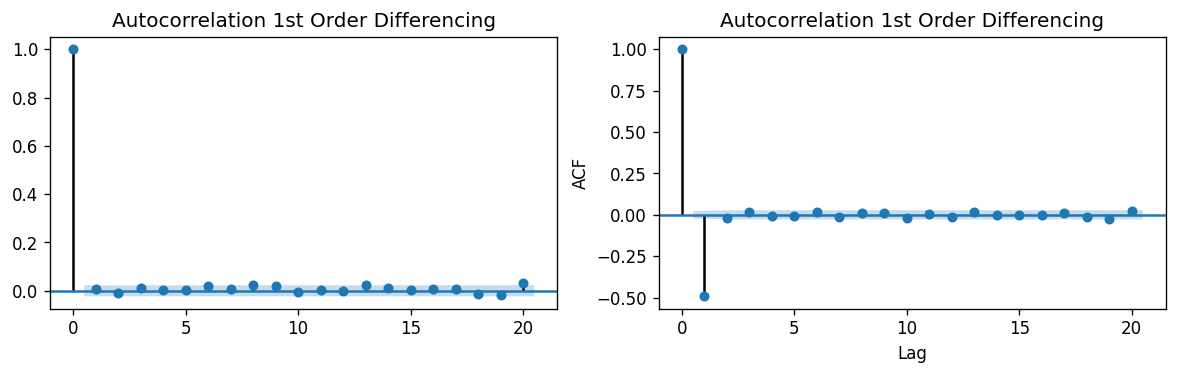

In [18]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(daily_series_diff1, lags=20, ax=axes[0], title="Autocorrelation 1st Order Differencing")
plot_acf(daily_series_diff2, lags=20, ax=axes[1], title="Autocorrelation 1st Order Differencing")
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [19]:
import pmdarima as pm
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=22716.078, BIC=22743.720, Time=0.444 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=22712.304, BIC=22726.125, Time=0.109 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=22714.079, BIC=22734.811, Time=0.335 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=22714.076, BIC=22734.808, Time=0.365 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=22710.304, BIC=22717.215, Time=0.075 seconds
Total fit time: 1.347 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7411
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -11354.152
Date:                Sat, 18 Apr 2020   AIC                          22710.304
Time:                        18:49:01   BIC                          22717.215
Sample:                        

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(1, 0, 1)).fit(transparams=False)
print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:218: RuntimeWarning: overflow encountered in square
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7411
Model:                     ARMA(1, 1)   Log Likelihood              -11357.899
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 18 Apr 2020   AIC                          22723.798
Time:                        18:49:04   BIC                          22751.441
Sample:                    01-02-2000   HQIC                         22733.296
                         - 04-16-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3145     16.991      3.785      0.000      31.013      97.616
ar.L1.y        0.9993      0.000   2298.278      0.000       0.998       1.000
ma.L1.y        0.0060      0.012      0.510      0.6

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1663: RuntimeWarning: invalid value encountered in double_scalars
  ('S.D. of innovations', ["%#5.3f" % self.sigma2 ** .5]),


In [21]:
ARIMA_Predict = model.predict(start='4/17/2020', end='9/30/2024')

In [22]:
ARIMA_Predict

2020-04-17    25.591255
2020-04-18    25.618785
2020-04-19    25.646295
2020-04-20    25.673786
2020-04-21    25.701256
                ...    
2024-09-26    52.105352
2024-09-27    52.114032
2024-09-28    52.122705
2024-09-29    52.131373
2024-09-30    52.140034
Freq: D, Length: 1628, dtype: float64

In [49]:
prediction = pd.DataFrame(ARIMA_Predict, columns=['predictions']).to_csv('prediction.csv')

In [50]:
############################

In [51]:
#pip install fbprophet

In [23]:
from fbprophet import Prophet
d={'ds':train['date'],'y':train['price']}
df_pred=pd.DataFrame(data=d)
model = Prophet(daily_seasonality=False)
model.fit(df_pred)

Importing plotly failed. Interactive plots will not work.


<Figure size 2160x720 with 0 Axes>

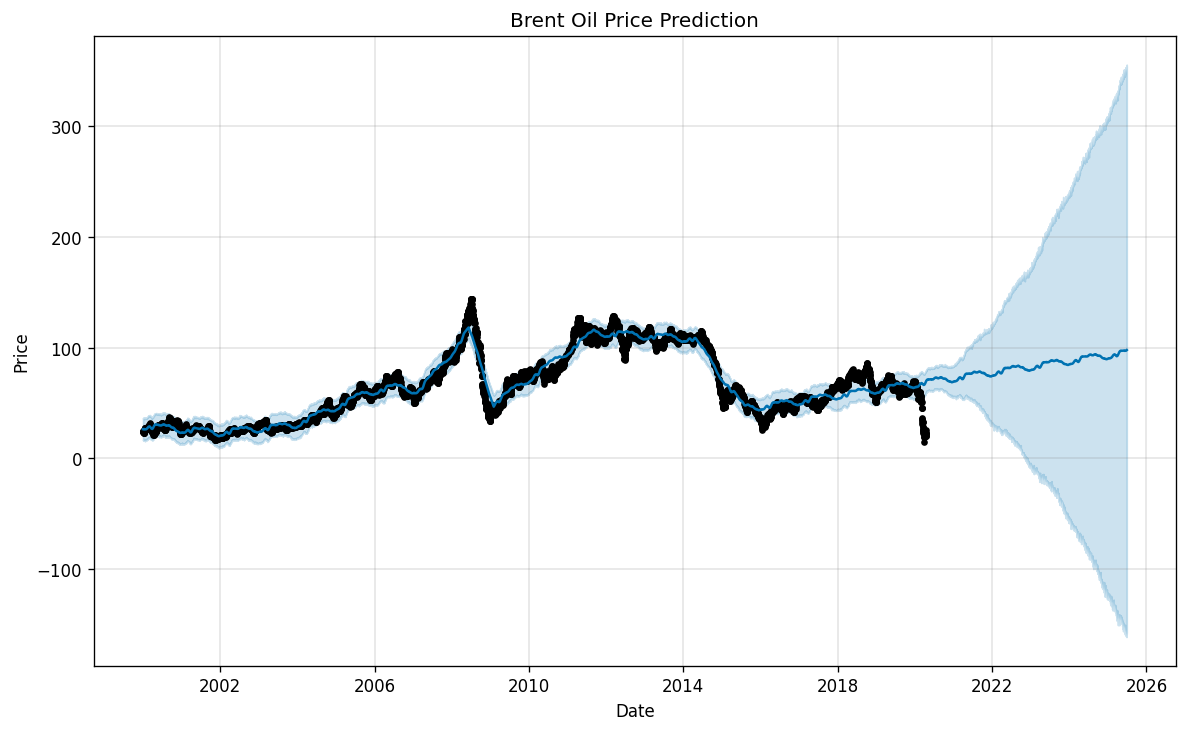

In [24]:
future = model.make_future_dataframe(periods=1900)
forecast = model.predict(future)
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Brent Oil Price Prediction');

In [74]:
forecast2019 = forecast[(forecast['ds' ] >= '2020-04-17') & (forecast['ds' ] <= '2020-09-30')] 

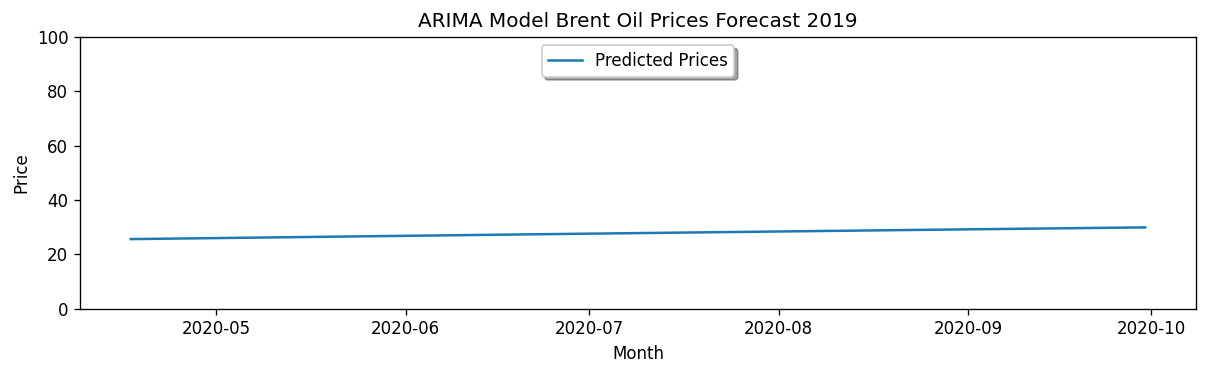

In [79]:
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], ARIMA_Predict, label='Predicted Prices')
ax.plot(test['date'], test['price'], )
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('ARIMA Model Brent Oil Prices Forecast 2019')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()